<a href="https://colab.research.google.com/github/JeevikaK/RobotLearningBenchmarking/blob/main/RL_with_CALVIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Reinforcement Learning with CALVIN</h1>

The **CALVIN** simulated benchmark is perfectly suited for training agents with reinforcement learning, in this notebook we will demonstrate how to integrate your agents to these environments.

## Installation
The first step is to install the CALVIN github repository such that we have access to the packages

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download repo
%mkdir /content/calvin
%cd /content/calvin
!git clone https://github.com/mees/calvin_env.git
%cd /content/calvin/calvin_env
!git clone https://github.com/lukashermann/tacto.git
# Install packages
%cd /content/calvin/calvin_env/tacto/
!pip3 install -e .
%cd /content/calvin/calvin_env
!pip3 install -e .
!pip3 install -U numpy
!pip3 install stable_baselines3
!pip install "shimmy>=2.0"

mkdir: cannot create directory ‘/content/calvin’: File exists
/content/calvin
fatal: destination path 'calvin_env' already exists and is not an empty directory.
/content/calvin/calvin_env
fatal: destination path 'tacto' already exists and is not an empty directory.
/content/calvin/calvin_env/tacto
Obtaining file:///content/calvin/calvin_env/tacto
  Preparing metadata (setup.py) ... done
  Using cached PyOpenGL-3.1.0-py3-none-any.whl
  Attempting uninstall: tacto
    Found existing installation: tacto 0.0.3
    Uninstalling tacto-0.0.3:
      Successfully uninstalled tacto-0.0.3
  Running setup.py develop for tacto
/content/calvin/calvin_env
Obtaining file:///content/calvin/calvin_env
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
^C


In [2]:
# Run this to check if the installation was succesful
from calvin_env.envs.play_table_env import PlayTableSimEnv

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/content/calvin/calvin_env/calvin_env/envs/play_table_env.py:289: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../../conf", config_name="config_data_collection")
/usr/local/lib/python

In [4]:
# 🧩 Use CALVIN debug dataset stored in Google Drive
import os

drive_dataset_path = "/content/drive/MyDrive/Dataset/calvin_debug_dataset"

# Check if dataset exists
if not os.path.exists(drive_dataset_path):
    raise FileNotFoundError(f"❌ Dataset not found at {drive_dataset_path}. Please check the path.")
else:
    print(f"✅ Found dataset at {drive_dataset_path}")


✅ Found dataset at /content/drive/MyDrive/Dataset/calvin_debug_dataset


## Loading the environment
After the installation has finished successfully, we can start using the environment for reinforcement Learning.
To be able to use the environment we need to have the appropriate configuration that define the desired features, for this example, we will load the static and gripper camera.

In [7]:
import os
from hydra import initialize_config_dir, compose

# Path to CALVIN config directory
config_dir = "/content/calvin/calvin_env/conf"
assert os.path.exists(config_dir), f"⚠️ Config folder not found at {config_dir}"

# Path to dataset in Google Drive
drive_dataset_path = "/content/drive/MyDrive/Dataset/calvin_debug_dataset"
assert os.path.exists(drive_dataset_path), f"⚠️ Dataset not found at {drive_dataset_path}"

with initialize_config_dir(config_dir=config_dir, version_base=None):
    cfg = compose(
        config_name="config_data_collection.yaml",
        overrides=[
            "cameras=static_and_gripper",
            f"+datamodule.root_data_dir={drive_dataset_path}",
            "+datamodule.datasets=vision_lang",
        ],
    )

    cfg.env["use_egl"] = False
    cfg.env["show_gui"] = False
    cfg.env["use_vr"] = False
    cfg.env["use_scene_info"] = True

    print("✅ Config loaded successfully!")
    print(cfg.env)

✅ Config loaded successfully!
{'_target_': 'calvin_env.envs.play_table_env.PlayTableSimEnv', '_recursive_': False, 'cameras': '${cameras}', 'seed': 0, 'bullet_time_step': 240.0, 'use_vr': False, 'show_gui': False, 'robot_cfg': '${robot}', 'scene_cfg': '${scene}', 'use_scene_info': True, 'use_egl': False, 'control_freq': 30}


/usr/local/lib/python3.12/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_data_collection.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


The environment has similar structure to traditional OpenAI Gym environments.

*   We can restart the simulation with the *reset* function.
*   We can perform an action in the environment with the *step* function.
*   We can visualize images taken from the cameras in the environment by using the *render* function.





Observation keys: dict_keys(['rgb_obs', 'depth_obs', 'robot_obs', 'scene_obs'])


/usr/local/lib/python3.12/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


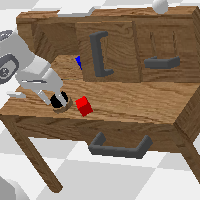

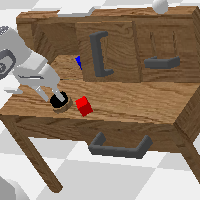

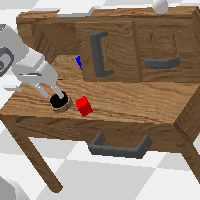

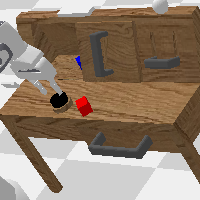

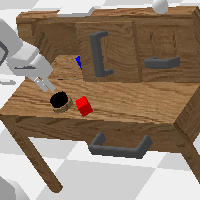

In [8]:
import time
import hydra
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Instantiate the environment using Hydra config
env = hydra.utils.instantiate(cfg.env)

# Reset the environment to get the first observation
observation = env.reset()
print("Observation keys:", observation.keys())

# Run a few random actions and visualize
for i in range(5):
    # Random pose displacement (6 values)
    action_displacement = np.random.uniform(low=-1, high=1, size=6)
    # Random gripper action (-1 = close, 1 = open)
    action_gripper = np.random.choice([-1, 1], size=1)
    # Combine both into one action vector
    action = np.concatenate((action_displacement, action_gripper), axis=-1)

    # Step the environment
    observation, reward, done, info = env.step(action)

    # Render RGB image (BGR → RGB for cv2_imshow)
    rgb = env.render(mode="rgb_array")[:, :, ::-1]
    cv2_imshow(rgb)
    time.sleep(0.5)

##  Custom environment for Reinforcement Learning
There are some aspects that needs to be defined to be able to use it for reinforcement learning, including:

1.   Observation space
2.   Action space
3.   Reward function

We are going to create a Custom environment that extends the **PlaytableSimEnv** to add these requirements. <br/>
The specific task that will be solved is called "move_slider_left", here you can find a [list of possible tasks](https://github.com/mees/calvin_env/blob/main/conf/tasks/new_playtable_tasks.yaml) that can be evaluated using CALVIN.



In [9]:
from gym import spaces
from calvin_env.envs.play_table_env import PlayTableSimEnv

class SlideEnv(PlayTableSimEnv):
    def __init__(self,
                 tasks: dict = {},
                 **kwargs):
        super(SlideEnv, self).__init__(**kwargs)
        # For this example we will modify the observation to
        # only retrieve the end effector pose
        self.action_space = spaces.Box(low=-1, high=1, shape=(7,))
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7,))
        # We can use the task utility to know if the task was executed correctly
        self.tasks = hydra.utils.instantiate(tasks)

    def reset(self):
        obs = super().reset()
        self.start_info = self.get_info()
        return obs

    def get_obs(self):
        """Overwrite robot obs to only retrieve end effector position"""
        robot_obs, robot_info = self.robot.get_observation()
        return robot_obs[:7]

    def _success(self):
        """ Returns a boolean indicating if the task was performed correctly """
        current_info = self.get_info()
        task_filter = ["move_slider_left"]
        task_info = self.tasks.get_task_info_for_set(self.start_info, current_info, task_filter)
        return 'move_slider_left' in task_info

    def _reward(self):
        """ Returns the reward function that will be used
        for the RL algorithm """
        reward = int(self._success()) * 10
        r_info = {'reward': reward}
        return reward, r_info

    def _termination(self):
        """ Indicates if the robot has reached a terminal state """
        success = self._success()
        done = success
        d_info = {'success': success}
        return done, d_info

    def step(self, action):
            """ Performing a relative action in the environment
                input:
                    action: 7 tuple containing
                            Position x, y, z.
                            Angle in rad x, y, z.
                            Gripper action
                            each value in range (-1, 1)

                            OR
                            8 tuple containing
                            Relative Joint angles j1 - j7 (in rad)
                            Gripper action
                output:
                    observation, reward, done info
            """
            # Transform gripper action to discrete space
            env_action = action.copy()
            env_action[-1] = (int(action[-1] >= 0) * 2) - 1

            # for using actions in joint space
            if len(env_action) == 8:
                env_action = {"action": env_action, "type": "joint_rel"}

            self.robot.apply_action(env_action)
            for i in range(self.action_repeat):
                self.p.stepSimulation(physicsClientId=self.cid)
            obs = self.get_obs()
            info = self.get_info()
            reward, r_info = self._reward()
            done, d_info = self._termination()
            info.update(r_info)
            info.update(d_info)
            return obs, reward, done, info

# Training an RL agent
After generating the wrapper training a reinforcement learning agent is straightforward, for this example we will use stable baselines 3 agents

To train the agent we create an instance of our new environment and send it to the stable baselines agent to learn a policy.


> Note: the example uses Soft Actor Critic (SAC) which is one of the state of the art algorithm for off-policy RL.



In [22]:
import gym
import numpy as np
from stable_baselines3 import SAC

new_env_cfg = {**cfg.env}
new_env_cfg["tasks"] = cfg.tasks
new_env_cfg.pop('_target_', None)
new_env_cfg.pop('_recursive_', None)
env = SlideEnv(**new_env_cfg)
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000, log_interval=4)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
model.save("sac_slide_env_debug")

In [32]:
import numpy as np

# Number of evaluation episodes
n_eval_episodes = 200

# Store total reward for each episode
episode_rewards = []

for ep in range(n_eval_episodes):
    obs = env.reset()
    done = False
    total_reward = 0.0
    step = 0

    while not done:
        action, _ = model.predict(obs)

        obs, reward, done, info = env.step(action)

        total_reward += reward
        step += 1

        if step >= 100:
            break

    episode_rewards.append(total_reward)

mean_reward = np.mean(episode_rewards)
std_reward = np.std(episode_rewards)

print(f"\nMean reward: {mean_reward:.2f} ± {std_reward:.2f}")



Mean reward: 0.70 ± 2.55


In [33]:
obs = env.reset()
frames = []
for _ in range(50):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    frames.append(env.render(mode="rgb_array"))
    if done:
        obs = env.reset()

import imageio
imageio.mimsave("rollout.gif", frames, fps=15)
print("Saved rollout.gif")


Saved rollout.gif


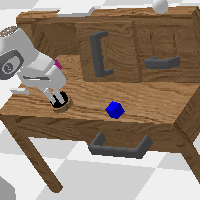

In [34]:
from IPython.display import Image, display

# Display the saved rollout GIF
display(Image(filename="rollout.gif"))